In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Basic Imports

In [57]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [58]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [59]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [60]:
from scipy.optimize import minimize

### Ansatz State

In [61]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [62]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [63]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [64]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [65]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [66]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [67]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [68]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [69]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [70]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [71]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [72]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [73]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [74]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [75]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [76]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)

## Visualization

In [77]:
approximated_energies = []

In [78]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [79]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[-NUM_ITERATIONS:])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [80]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [81]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:05,  4.66it/s]
27it [00:06,  3.99it/s]
27it [00:06,  4.29it/s]
27it [00:06,  4.28it/s]
27it [00:06,  4.26it/s]
27it [00:06,  4.25it/s]
27it [00:06,  4.49it/s]
27it [00:06,  4.37it/s]
27it [00:06,  4.33it/s]
27it [00:06,  4.06it/s]
27it [00:06,  3.91it/s]
27it [00:06,  3.86it/s]
27it [00:05,  4.57it/s]
27it [00:05,  5.00it/s]
27it [00:05,  5.07it/s]
27it [00:05,  4.95it/s]
27it [00:05,  4.99it/s]
27it [00:05,  5.17it/s]
27it [00:04,  5.46it/s]
27it [00:05,  4.77it/s]
27it [00:05,  5.19it/s]
27it [00:05,  5.00it/s]
27it [00:05,  5.14it/s]
27it [00:05,  5.35it/s]
27it [00:05,  5.20it/s]
27it [00:05,  5.08it/s]
27it [00:05,  4.86it/s]
27it [00:05,  5.32it/s]
27it [00:05,  5.00it/s]
27it [00:05,  5.19it/s]
27it [00:05,  5.35it/s]
27it [00:05,  5.24it/s]
27it [00:05,  5.20it/s]
27it [00:05,  5.02it/s]
27it [00:05,  5.34it/s]
27it [00:05,  5.26it/s]
27it [00:05,  4.88it/s]
27it [00:05,  4.87it/s]
27it [00:04,  5.42it/s]
27it [00:05,  5.15it/s]
27it [00:05,  5.35it/s]
27it [00:05,  4.

[6.141692   4.64846109 5.47619426 2.75554705 1.77234912 5.98051722
 4.31358205 2.16847228 1.48764102 3.16785156 4.71275385 2.85647092
 4.21610032 2.51538189 5.12289611 4.99471199 0.72934467 2.95734331
 3.99477575 3.62776512 0.73022461 0.22278245 4.72116059 5.7551255
 0.72716467 5.39573056 1.69040609 3.13813471 3.3385178  2.07425556
 0.49933985 2.03923428]


27it [00:05,  5.37it/s]

CPU times: total: 13min 7s
Wall time: 23min 11s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.679787126114672

Approximation Error
0.02327245529271241


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


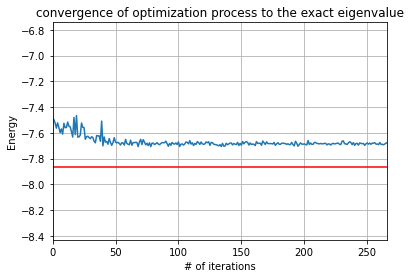

In [82]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [83]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:05,  4.50it/s]
27it [00:05,  5.25it/s]
27it [00:04,  5.77it/s]
27it [00:05,  5.18it/s]
27it [00:04,  5.57it/s]
27it [00:05,  5.30it/s]
27it [00:04,  6.07it/s]
27it [00:04,  5.91it/s]
27it [00:04,  5.81it/s]
27it [00:04,  6.17it/s]
27it [00:03,  6.77it/s]
27it [00:04,  6.17it/s]
27it [00:04,  5.90it/s]
27it [00:04,  6.11it/s]
27it [00:04,  5.48it/s]
27it [00:04,  5.72it/s]
27it [00:04,  5.78it/s]
27it [00:04,  5.68it/s]
27it [00:05,  5.25it/s]
27it [00:04,  5.92it/s]
27it [00:04,  6.04it/s]
27it [00:04,  5.85it/s]
27it [00:04,  6.10it/s]
27it [00:04,  6.12it/s]
27it [00:04,  5.78it/s]
27it [00:04,  6.10it/s]
27it [00:04,  6.27it/s]
27it [00:04,  5.99it/s]
27it [00:05,  5.10it/s]
27it [00:05,  5.25it/s]
27it [00:04,  6.57it/s]
27it [00:04,  5.47it/s]
27it [00:04,  5.74it/s]
27it [00:04,  6.23it/s]
27it [00:04,  6.39it/s]
27it [00:05,  5.36it/s]
27it [00:04,  5.46it/s]
27it [00:04,  5.82it/s]
27it [00:04,  6.06it/s]
27it [00:05,  5.39it/s]
27it [00:04,  6.06it/s]
27it [00:04,  5.

27it [00:04,  6.38it/s]
27it [00:04,  6.30it/s]
27it [00:04,  5.82it/s]
27it [00:04,  6.15it/s]
27it [00:04,  6.02it/s]
27it [00:04,  5.96it/s]
27it [00:04,  5.65it/s]
27it [00:04,  5.60it/s]
27it [00:04,  6.07it/s]
27it [00:04,  5.91it/s]
27it [00:05,  5.21it/s]
27it [00:05,  5.10it/s]
27it [00:04,  5.79it/s]
27it [00:04,  5.98it/s]


[ 3.13685927  4.33291967  4.15300968  5.18221829  1.34559976  1.81515305
  1.19006451  1.00623849  1.19250509  5.49708359  6.00141548  0.25154217
  6.34407268  4.37960865  3.20296735  6.93061096  5.15417593  4.4595261
  2.93602088  4.36976661  0.84227599  2.07611144  1.79992945  1.29621415
  5.44387911  3.42854084 -0.47839036  2.72000097  0.22820298  0.6202969
  0.59568256  3.60363998]


27it [00:04,  6.43it/s]

CPU times: total: 18min 5s
Wall time: 27min 37s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.804127301429666

Approximation Error
0.007458673979566805


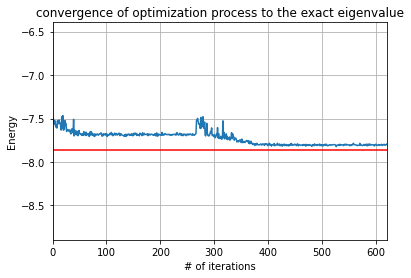

In [84]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [85]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [86]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:02,  5.64it/s]
15it [00:02,  6.45it/s]
15it [00:02,  6.65it/s]
15it [00:02,  6.27it/s]
15it [00:02,  5.47it/s]
15it [00:02,  6.11it/s]
15it [00:02,  5.49it/s]
15it [00:02,  5.48it/s]
15it [00:02,  5.65it/s]
15it [00:02,  6.37it/s]
15it [00:02,  6.15it/s]
15it [00:02,  5.53it/s]
15it [00:02,  5.74it/s]
15it [00:02,  5.89it/s]
15it [00:02,  6.19it/s]
15it [00:02,  5.71it/s]
15it [00:02,  5.98it/s]
15it [00:02,  6.70it/s]
15it [00:02,  5.88it/s]
15it [00:02,  6.24it/s]
15it [00:02,  5.91it/s]
15it [00:02,  5.64it/s]
15it [00:02,  6.11it/s]
15it [00:02,  5.16it/s]
15it [00:02,  6.16it/s]
15it [00:02,  5.17it/s]
15it [00:02,  6.59it/s]
15it [00:02,  6.12it/s]
15it [00:02,  6.03it/s]
15it [00:02,  5.03it/s]
15it [00:02,  5.87it/s]
15it [00:02,  5.82it/s]
15it [00:02,  5.72it/s]
15it [00:02,  5.33it/s]
15it [00:02,  6.07it/s]
15it [00:02,  5.67it/s]
15it [00:02,  5.93it/s]
15it [00:02,  6.78it/s]
15it [00:02,  6.67it/s]
15it [00:02,  6.38it/s]
15it [00:02,  5.58it/s]
15it [00:02,  6.

[ 1.03907004e+00  1.41786335e+00  4.04502220e+00  6.71366459e-01
  5.02552015e-01  3.63357101e-01  3.26902481e+00  4.35941854e+00
  1.85682962e+00  1.90883152e+00  3.34433567e-01  7.59763264e-01
  5.35741829e+00  4.12624511e+00  3.71855974e+00  6.22028677e+00
  2.35469802e+00  4.24180734e+00  2.26266174e+00  2.14060845e+00
  1.01732983e+00  1.33913628e+00  4.39892651e-01  5.49820009e-01
  2.18518940e+00  2.58985593e+00  4.14873555e-01  5.66990740e+00
 -6.19730409e-04  7.73209289e-02  6.06761854e+00 -1.22696600e-02]


15it [00:02,  6.17it/s]

CPU times: total: 7min 13s
Wall time: 10min 19s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.290394824648923

Approximation Error
0.30522146496078495


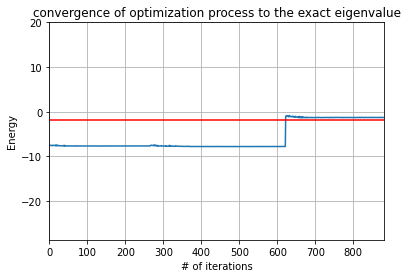

In [87]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [88]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:02,  7.06it/s]
15it [00:02,  6.21it/s]
15it [00:02,  5.68it/s]
15it [00:02,  6.64it/s]
15it [00:02,  6.38it/s]
15it [00:02,  7.04it/s]
15it [00:02,  6.61it/s]
15it [00:02,  7.08it/s]
15it [00:02,  6.61it/s]
15it [00:02,  7.06it/s]
15it [00:02,  6.19it/s]
15it [00:02,  6.74it/s]
15it [00:02,  6.22it/s]
15it [00:02,  6.62it/s]
15it [00:02,  7.09it/s]
15it [00:02,  6.80it/s]
15it [00:02,  6.95it/s]
15it [00:02,  5.85it/s]
15it [00:02,  6.91it/s]
15it [00:02,  6.22it/s]
15it [00:02,  6.71it/s]
15it [00:02,  6.32it/s]
15it [00:02,  6.31it/s]
15it [00:02,  6.63it/s]
15it [00:02,  5.80it/s]
15it [00:02,  7.09it/s]
15it [00:02,  6.43it/s]
15it [00:02,  6.60it/s]
15it [00:02,  6.98it/s]
15it [00:02,  7.00it/s]
15it [00:02,  7.43it/s]
15it [00:02,  6.43it/s]
15it [00:02,  6.35it/s]
15it [00:02,  6.23it/s]
15it [00:02,  6.91it/s]
15it [00:02,  6.16it/s]
15it [00:02,  6.75it/s]
15it [00:02,  6.25it/s]
15it [00:02,  6.50it/s]
15it [00:02,  6.83it/s]
15it [00:02,  6.96it/s]
15it [00:02,  6.

[0.27374489 1.65821555 5.93173251 2.97000192 5.1334673  0.12113593
 3.1822402  4.37700254 4.66094935 3.36665209 3.43382271 4.38116867
 3.63766892 5.47742644 3.9905248  3.42968514 4.18897166 7.0192732
 2.84793252 1.68826603 5.71296356 0.75822992 2.30779312 4.08407242
 3.93901815 4.29143025 2.66324366 3.22438841 5.92578807 3.03397292
 4.08870802 2.87632065]


15it [00:02,  5.94it/s]

CPU times: total: 9min 7s
Wall time: 12min 14s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.4672676668691669

Approximation Error
0.2099890199302981


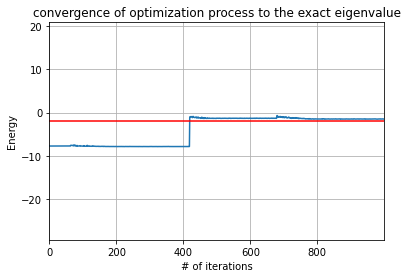

In [89]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [90]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [91]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:01,  6.13it/s]
11it [00:01,  6.77it/s]
11it [00:01,  5.63it/s]
11it [00:01,  6.69it/s]
11it [00:01,  6.33it/s]
11it [00:01,  6.01it/s]
11it [00:01,  6.82it/s]
11it [00:01,  7.28it/s]
11it [00:01,  6.99it/s]
11it [00:01,  6.64it/s]
11it [00:01,  6.24it/s]
11it [00:01,  6.30it/s]
11it [00:01,  6.84it/s]
11it [00:01,  6.27it/s]
11it [00:01,  6.82it/s]
11it [00:01,  6.32it/s]
11it [00:01,  6.08it/s]
11it [00:01,  7.06it/s]
11it [00:01,  5.91it/s]
11it [00:01,  6.73it/s]
11it [00:01,  7.16it/s]
11it [00:01,  6.61it/s]
11it [00:01,  6.34it/s]
11it [00:01,  6.10it/s]
11it [00:01,  7.25it/s]
11it [00:01,  6.85it/s]
11it [00:01,  7.80it/s]
11it [00:01,  6.78it/s]
11it [00:01,  6.80it/s]
11it [00:01,  7.41it/s]
11it [00:01,  6.60it/s]
11it [00:01,  7.02it/s]
11it [00:01,  6.76it/s]
11it [00:01,  6.44it/s]
11it [00:01,  6.88it/s]
11it [00:01,  6.51it/s]
11it [00:01,  6.38it/s]
11it [00:01,  7.43it/s]
11it [00:01,  6.69it/s]
11it [00:01,  6.49it/s]
11it [00:01,  6.66it/s]
11it [00:01,  7.

11it [00:01,  7.96it/s]
11it [00:01,  7.86it/s]
11it [00:01,  8.04it/s]
11it [00:01,  7.40it/s]
11it [00:01,  7.68it/s]


[2.82189558 6.40545357 1.5505784  7.40860546 6.99268414 6.23739944
 3.26197799 3.58518849 3.37650285 2.71138989 1.54982598 1.55361145
 2.75142471 0.15234321 4.45253432 2.80160333 5.73671433 5.3053821
 1.31587761 4.69380737 4.85875879 3.03550828 0.4254797  3.0412188
 0.29726426 0.86397031 1.72332819 4.34059117 3.11103769 4.05286847
 1.24282157 0.84707186]


11it [00:01,  7.50it/s]

CPU times: total: 7min 5s
Wall time: 9min 9s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-2.218155631137159

Approximation Error
0.10936315484712932


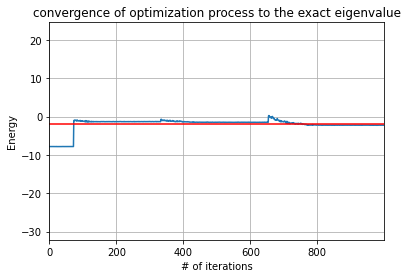

In [92]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [93]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:01,  7.13it/s]
11it [00:01,  7.50it/s]
11it [00:01,  7.23it/s]
11it [00:01,  7.22it/s]
11it [00:01,  7.85it/s]
11it [00:01,  7.20it/s]
11it [00:01,  7.36it/s]
11it [00:01,  7.62it/s]
11it [00:01,  8.45it/s]
11it [00:01,  8.35it/s]
11it [00:01,  7.41it/s]
11it [00:01,  7.91it/s]
11it [00:01,  8.78it/s]
11it [00:01,  8.81it/s]
11it [00:01,  7.93it/s]
11it [00:01,  7.17it/s]
11it [00:01,  7.26it/s]
11it [00:01,  6.99it/s]
11it [00:01,  7.91it/s]
11it [00:01,  7.82it/s]
11it [00:01,  7.43it/s]
11it [00:01,  6.87it/s]
11it [00:01,  8.41it/s]
11it [00:01,  7.77it/s]
11it [00:01,  7.71it/s]
11it [00:01,  8.48it/s]
11it [00:01,  7.51it/s]
11it [00:01,  6.75it/s]
11it [00:01,  8.38it/s]
11it [00:01,  8.39it/s]
11it [00:01,  7.24it/s]
11it [00:01,  7.45it/s]
11it [00:01,  7.19it/s]
11it [00:01,  7.32it/s]
11it [00:01,  6.42it/s]
11it [00:01,  7.87it/s]
11it [00:01,  7.96it/s]
11it [00:01,  6.95it/s]
11it [00:01,  6.38it/s]
11it [00:01,  6.86it/s]
11it [00:01,  7.53it/s]
11it [00:01,  7.

11it [00:01,  7.90it/s]
11it [00:01,  7.45it/s]
11it [00:01,  7.01it/s]
11it [00:01,  7.41it/s]
11it [00:01,  7.27it/s]
11it [00:01,  6.89it/s]
11it [00:01,  7.17it/s]
11it [00:01,  7.03it/s]
11it [00:01,  7.25it/s]
11it [00:01,  6.91it/s]
11it [00:01,  7.26it/s]
11it [00:01,  7.56it/s]
11it [00:01,  7.53it/s]
11it [00:01,  7.19it/s]
11it [00:01,  6.88it/s]
11it [00:01,  7.14it/s]
11it [00:01,  7.60it/s]
11it [00:01,  7.47it/s]
11it [00:01,  6.91it/s]
11it [00:01,  6.54it/s]
11it [00:01,  7.94it/s]
11it [00:01,  7.34it/s]
11it [00:01,  7.03it/s]
11it [00:01,  7.44it/s]
11it [00:01,  7.75it/s]
11it [00:01,  7.17it/s]
11it [00:01,  7.74it/s]
11it [00:01,  7.25it/s]
11it [00:01,  7.36it/s]
11it [00:01,  7.16it/s]
11it [00:01,  7.38it/s]
11it [00:01,  7.59it/s]
11it [00:01,  7.04it/s]
11it [00:01,  7.09it/s]
11it [00:01,  7.81it/s]
11it [00:01,  6.89it/s]
11it [00:01,  7.32it/s]
11it [00:01,  7.22it/s]
11it [00:01,  7.14it/s]
11it [00:01,  7.17it/s]
11it [00:01,  7.49it/s]
11it [00:01,  7.

[6.42243648 1.00144618 5.52567158 7.39813778 4.80968663 2.94864268
 2.16004704 2.49969437 6.16486115 0.87795305 1.76417563 5.91497428
 4.69880898 5.64443794 1.85009316 3.4550554  3.11438961 1.18852404
 2.22952192 5.66474264 3.4480551  5.49758262 4.06516213 6.26922277
 3.92229243 2.7632068  2.516281   1.58839007 0.38885881 5.17629789
 7.005222   6.4680554 ]


11it [00:01,  6.87it/s]

CPU times: total: 8min 24s
Wall time: 9min 53s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-2.1035190551483764

Approximation Error
0.05203012022385919


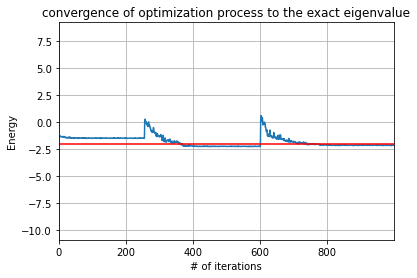

In [94]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [95]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [96]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [97]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00,  9.94it/s]
7it [00:00, 10.28it/s]
7it [00:00,  8.55it/s]
7it [00:00,  8.89it/s]
7it [00:00, 10.51it/s]
7it [00:00,  9.16it/s]
7it [00:00,  8.46it/s]
7it [00:00,  9.24it/s]
7it [00:00,  9.18it/s]
7it [00:00, 10.34it/s]
7it [00:00, 10.53it/s]
7it [00:00, 11.32it/s]
7it [00:00,  9.40it/s]
7it [00:00,  9.86it/s]
7it [00:00,  9.02it/s]
7it [00:00,  9.84it/s]
7it [00:00,  9.99it/s]
7it [00:00, 10.62it/s]
7it [00:00, 10.14it/s]
7it [00:00,  9.92it/s]
7it [00:00, 10.23it/s]
7it [00:00,  8.96it/s]
7it [00:00,  9.55it/s]
7it [00:00,  9.88it/s]
7it [00:00, 10.15it/s]
7it [00:00,  9.73it/s]
7it [00:00, 10.60it/s]
7it [00:00,  9.63it/s]
7it [00:00, 10.40it/s]
7it [00:00,  9.70it/s]
7it [00:00,  7.78it/s]
7it [00:00,  9.26it/s]
7it [00:00,  9.35it/s]
7it [00:00,  9.56it/s]
7it [00:00, 10.17it/s]
7it [00:00,  9.88it/s]
7it [00:00,  8.78it/s]
7it [00:00, 11.46it/s]
7it [00:00, 11.07it/s]
7it [00:00, 11.43it/s]
7it [00:00, 11.24it/s]
7it [00:00, 11.49it/s]
7it [00:00, 11.17it/s]
7it [00:00,

[1.61687018 4.49460682 2.60435099 1.81676548 5.58174227 2.48869129
 1.45394614 6.7843299  4.72284625 4.41221425 6.28930884 4.30536715
 1.38840021 0.25560714 2.73316447 3.23583546 5.09771527 1.34832512
 1.398043   2.73211205 5.52444442 1.01704971 3.30833914 3.09672441]


7it [00:00,  9.59it/s]

CPU times: total: 2min 26s
Wall time: 2min 52s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-1.0389784952302865

Approximation Error
0.08274994870315003


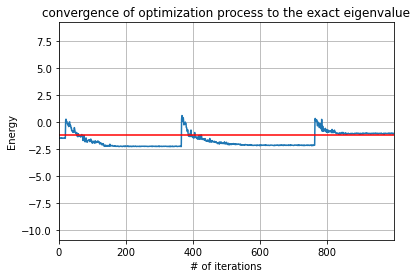

In [98]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [99]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00,  9.68it/s]
7it [00:00,  9.01it/s]
7it [00:00, 11.24it/s]
7it [00:00,  8.19it/s]
7it [00:00,  8.28it/s]
7it [00:00,  8.11it/s]
7it [00:00,  8.39it/s]
7it [00:00, 10.98it/s]
7it [00:00, 10.31it/s]
7it [00:00, 10.19it/s]
7it [00:00, 10.83it/s]
7it [00:00,  9.17it/s]
7it [00:00,  8.99it/s]
7it [00:00,  8.91it/s]
7it [00:00,  9.99it/s]
7it [00:00,  8.13it/s]
7it [00:00, 10.00it/s]
7it [00:00,  8.56it/s]
7it [00:00, 10.67it/s]
7it [00:00,  9.47it/s]
7it [00:00,  9.40it/s]
7it [00:00,  9.18it/s]
7it [00:00,  9.47it/s]
7it [00:00,  9.76it/s]
7it [00:00, 10.79it/s]
7it [00:00, 10.51it/s]
7it [00:00, 10.34it/s]
7it [00:00,  9.19it/s]
7it [00:00,  8.68it/s]
7it [00:00, 10.40it/s]
7it [00:00,  9.13it/s]
7it [00:00,  9.25it/s]
7it [00:00,  8.93it/s]
7it [00:00,  8.95it/s]
7it [00:00,  8.74it/s]
7it [00:00,  9.67it/s]
7it [00:00,  9.68it/s]
7it [00:00,  9.72it/s]
7it [00:00, 10.11it/s]
7it [00:00,  9.51it/s]
7it [00:00, 11.08it/s]
7it [00:00, 11.08it/s]
7it [00:00, 11.75it/s]
7it [00:00,

[-0.34536924  2.03955615  2.84544134  1.24498657  2.15778836  0.85219848
  2.670378    3.72389231  2.77617051  2.91047175  2.41321228  5.05064671
  4.54847198  2.93458809  3.0027516   2.86573966  1.40314767 -0.54798965
  1.38266964  1.95602496  3.86175258  3.48196732  2.9357374   4.82129226]


7it [00:00,  9.08it/s]

CPU times: total: 2min 15s
Wall time: 2min 42s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.9111601215664635

Approximation Error
0.19559290968651027


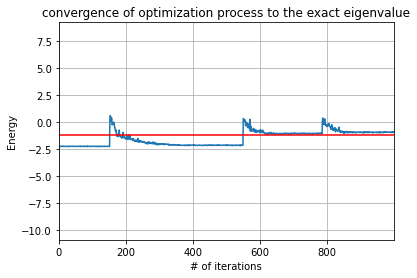

In [100]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [101]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [102]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [103]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 14.18it/s]
3it [00:00, 14.14it/s]
3it [00:00, 13.86it/s]
3it [00:00, 13.57it/s]
3it [00:00, 12.17it/s]
3it [00:00, 15.00it/s]
3it [00:00, 14.67it/s]
3it [00:00, 11.90it/s]
3it [00:00, 14.63it/s]
3it [00:00, 14.96it/s]
3it [00:00, 15.15it/s]
3it [00:00, 12.63it/s]
3it [00:00, 16.00it/s]
3it [00:00, 15.87it/s]
3it [00:00, 14.96it/s]
3it [00:00, 14.74it/s]
3it [00:00, 15.71it/s]
3it [00:00, 14.46it/s]
3it [00:00, 16.35it/s]
3it [00:00, 15.96it/s]
3it [00:00, 16.26it/s]
3it [00:00, 15.96it/s]
3it [00:00, 15.92it/s]
3it [00:00, 15.50it/s]
3it [00:00, 16.48it/s]
3it [00:00, 15.31it/s]
3it [00:00, 16.44it/s]
3it [00:00, 16.00it/s]
3it [00:00, 14.18it/s]
3it [00:00, 12.96it/s]
3it [00:00, 14.32it/s]
3it [00:00, 16.00it/s]
3it [00:00,  9.24it/s]
3it [00:00, 14.29it/s]
3it [00:00, 14.95it/s]
3it [00:00, 11.42it/s]
3it [00:00, 14.42it/s]
3it [00:00, 13.53it/s]
3it [00:00, 10.28it/s]
3it [00:00, 13.58it/s]
3it [00:00, 15.23it/s]
3it [00:00, 10.50it/s]
3it [00:00, 12.47it/s]
3it [00:00,

[ 1.90782336  0.47701147  1.68280424  1.32411796  4.12669492  3.43612975
  6.40917462  5.18147649 -0.55025326  4.43045944 -0.71261696  3.07387755
  1.73022025  2.24956016  1.43448592  4.30677885]


3it [00:00, 16.26it/s]

CPU times: total: 35.2 s
Wall time: 41.2 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.1131311190868678

Approximation Error
0.08389362102003091


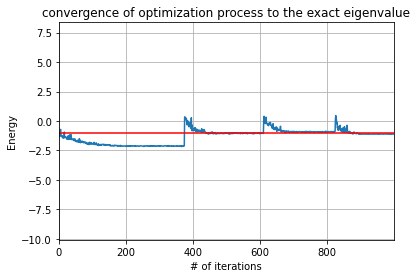

In [104]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [105]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 14.77it/s]
3it [00:00, 16.00it/s]
3it [00:00, 13.50it/s]
3it [00:00, 14.30it/s]
3it [00:00, 13.95it/s]
3it [00:00, 13.92it/s]
3it [00:00, 14.25it/s]
3it [00:00, 14.35it/s]
3it [00:00, 13.82it/s]
3it [00:00, 15.15it/s]
3it [00:00, 12.26it/s]
3it [00:00, 13.57it/s]
3it [00:00, 11.64it/s]
3it [00:00, 15.19it/s]
3it [00:00, 14.78it/s]
3it [00:00, 13.10it/s]
3it [00:00, 15.19it/s]
3it [00:00, 12.88it/s]
3it [00:00, 12.29it/s]
3it [00:00, 12.90it/s]
3it [00:00, 15.92it/s]
3it [00:00, 15.38it/s]
3it [00:00, 14.46it/s]
3it [00:00, 11.90it/s]
3it [00:00, 14.18it/s]
3it [00:00, 16.26it/s]
3it [00:00, 15.58it/s]
3it [00:00,  9.23it/s]
3it [00:00, 13.99it/s]
3it [00:00, 14.49it/s]
3it [00:00, 15.47it/s]
3it [00:00, 15.23it/s]
3it [00:00, 16.09it/s]
3it [00:00, 11.82it/s]
3it [00:00, 14.74it/s]
3it [00:00, 13.71it/s]
3it [00:00, 15.92it/s]
3it [00:00, 12.24it/s]
3it [00:00, 16.53it/s]
3it [00:00, 15.15it/s]
3it [00:00,  9.59it/s]
3it [00:00, 14.35it/s]
3it [00:00, 15.91it/s]
3it [00:00,

[2.37113367 3.69469525 4.55976238 1.31994911 3.27525216 0.53021951
 4.43971978 0.21658703 3.81965661 2.26252256 0.90621142 5.39720501
 3.39824066 2.12984237 1.85281535 4.62658561]


3it [00:00, 12.02it/s]

CPU times: total: 29.8 s
Wall time: 35.6 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.148085314296954

Approximation Error
0.11792970946141852


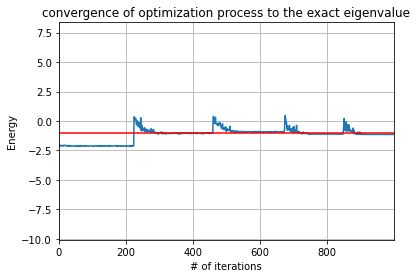

In [106]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [107]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [108]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 13.20it/s]
4it [00:00,  9.15it/s]
4it [00:00, 12.74it/s]
4it [00:00, 14.87it/s]
4it [00:00, 14.95it/s]
4it [00:00, 10.71it/s]
4it [00:00, 15.09it/s]
4it [00:00, 14.57it/s]
4it [00:00, 11.82it/s]
4it [00:00, 12.64it/s]
4it [00:00, 17.03it/s]
4it [00:00, 12.02it/s]
4it [00:00, 15.56it/s]
4it [00:00,  7.89it/s]
4it [00:00,  9.02it/s]
4it [00:00, 11.96it/s]
4it [00:00, 10.94it/s]
4it [00:00, 11.96it/s]
4it [00:00, 12.08it/s]
4it [00:00, 10.04it/s]
4it [00:00, 13.45it/s]
4it [00:00, 10.47it/s]
4it [00:00, 15.24it/s]
4it [00:00, 13.68it/s]
4it [00:00, 14.26it/s]
4it [00:00, 14.06it/s]
4it [00:00, 15.44it/s]
4it [00:00, 14.55it/s]
4it [00:00, 15.21it/s]
4it [00:00, 11.96it/s]
4it [00:00, 11.05it/s]
4it [00:00, 11.52it/s]
4it [00:00,  8.94it/s]
4it [00:00, 12.24it/s]
4it [00:00, 15.33it/s]
4it [00:00, 13.07it/s]
4it [00:00, 12.92it/s]
4it [00:00, 14.87it/s]
4it [00:00, 14.68it/s]
4it [00:00, 12.95it/s]
4it [00:00, 14.98it/s]
4it [00:00, 14.47it/s]
4it [00:00, 14.68it/s]
4it [00:00,

[1.52151103 2.40925843 1.42369183 1.24259511 3.98209253 5.15449114
 3.6065297  4.75969081 3.42370849 1.63253361 2.53051253 3.97999306
 1.39453635 3.05638938 1.3810635  3.8217105 ]


4it [00:00, 13.08it/s]

CPU times: total: 41.1 s
Wall time: 50 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9979533872326604

Approximation Error
0.007116973367921446


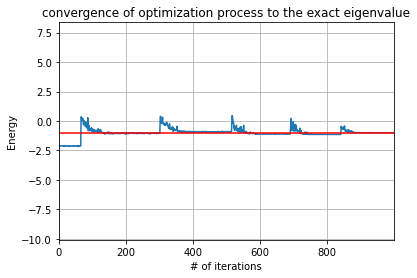

In [109]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [110]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00, 12.40it/s]
4it [00:00, 13.29it/s]
4it [00:00, 14.02it/s]
4it [00:00, 13.99it/s]
4it [00:00, 14.60it/s]
4it [00:00, 14.44it/s]
4it [00:00, 14.79it/s]
4it [00:00, 13.45it/s]
4it [00:00, 14.36it/s]
4it [00:00, 15.90it/s]
4it [00:00, 15.56it/s]
4it [00:00, 14.18it/s]
4it [00:00, 15.07it/s]
4it [00:00, 13.98it/s]
4it [00:00, 14.89it/s]
4it [00:00, 10.93it/s]
4it [00:00, 14.73it/s]
4it [00:00, 13.19it/s]
4it [00:00, 13.77it/s]
4it [00:00, 12.29it/s]
4it [00:00, 15.50it/s]
4it [00:00, 10.93it/s]
4it [00:00,  8.23it/s]
4it [00:00, 14.84it/s]
4it [00:00, 15.30it/s]
4it [00:00, 15.56it/s]
4it [00:00, 10.65it/s]
4it [00:00, 13.68it/s]
4it [00:00, 13.37it/s]
4it [00:00,  9.74it/s]
4it [00:00, 14.60it/s]
4it [00:00,  7.80it/s]
4it [00:00,  9.63it/s]
4it [00:00, 16.16it/s]
4it [00:00, 15.47it/s]
4it [00:00, 13.47it/s]
4it [00:00, 13.56it/s]
4it [00:00, 13.96it/s]
4it [00:00, 14.18it/s]
4it [00:00, 14.79it/s]
4it [00:00, 14.93it/s]
4it [00:00, 15.63it/s]
4it [00:00, 15.38it/s]
4it [00:00,

[0.46446287 2.13162542 4.10911213 1.96060435 3.814336   3.59995975
 1.90276105 5.15666956 1.90580265 2.70694049 2.21234615 3.24638011
 4.94868317 4.5527961  0.67505926 0.11253066]


4it [00:00, 12.90it/s]

CPU times: total: 44.3 s
Wall time: 53 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9978413914975226

Approximation Error
0.007228400079725912


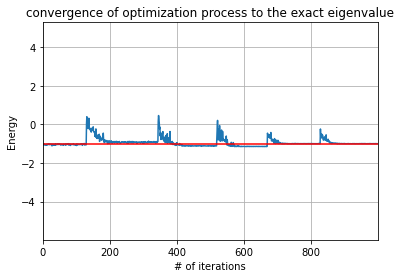

In [111]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)